# Analyze motion data from SenseHAT

With the TjBot based on Raspberry Pi the motion sensor data (acc, gyro, compass, ..) from the SenseHAT will be pushed through the IoT Foundation via MQTT into a cloudant DB.


With this python notebook you will be able to 

* collect this data and create some visualisations
* and to train a support vector classifier

## Get acces to database

### Install the necessary python libraries missing by default

In [1]:
!pip install cloudant

Requirement not upgraded as not directly required: cloudant in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: requests<3.0.0,>=2.7.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from cloudant)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0.0,>=2.7.0->cloudant)
Requirement not upgraded as not directly required: idna<2.7,>=2.5 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0.0,>=2.7.0->cloudant)
Requirement not upgraded as not directly required: urllib3<1.23,>=1.21.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0.0,>=2.7.0->cloudant)
Requirement not upgraded as not directly required: certifi>=2017.4.17 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0.0,>=2.7.0->cloudant)


### Get the credentials to access the cloudant DB

In [2]:
# The code was removed by Watson Studio for sharing.

### Create a cloudant client

In [3]:
from cloudant.client import Cloudant
from cloudant.result import Result, ResultByKey
from cloudant.query import Query

client = Cloudant(credentials['username'], credentials['password'], url=credentials['custom_url'], connect=True)

### Select the database

In [4]:
database  = client['sensehat_motion']

### Construct a Query for Motion messages

In [5]:
# Select statement for document selection
selector = {
    '_id':{'$gt': 0},
    'payload.d.motionset': {
        '$gte': '2018-12-16T08:00',  # $gte: greater than or equal
        '$lt': '2018-12-17T00:00'},  # $lte: less than or equal
}

# Selected fields of the document
fields = [
    'payload.d.device',
    'payload.d.userid',
    'payload.d.figure',
    'payload.d.motionset',
    'payload.d.timestamp',
    'payload.d.date',
    'payload.d.acceleration',
    'payload.d.gyroscope',
    'payload.d.orientation.roll',
    'payload.d.orientation.pitch',
    'payload.d.orientation.yaw',
    'payload.d.compass'
]

# Create the query and get a handler
motion_query = Query(
    database,
    selector=selector,
    fields= fields
)

In [6]:
# show the two elements from the cloudant DB
for doc in motion_query(limit=2)['docs']:
    print(doc)

{'payload': {'d': {'userid': 25, 'compass': 267, 'gyroscope': {'x': 0.7205, 'y': 0.1701, 'z': -0.4047}, 'motionset': '2018-12-16T09:22:52.975Z', 'acceleration': {'x': 0.7043, 'y': 0.1088, 'z': 0.0502}, 'device': 'tjbot-01', 'timestamp': 1544952173255, 'orientation': {'pitch': 272.4581, 'roll': 174.0104, 'yaw': 266.6693}, 'figure': '0', 'date': '2018-12-16T09:22:53.255Z'}}}
{'payload': {'d': {'userid': 25, 'compass': 29, 'gyroscope': {'x': 0.2755, 'y': 0.8891, 'z': -0.314}, 'motionset': '2018-12-16T09:22:52.975Z', 'acceleration': {'x': 0.6723, 'y': -0.2957, 'z': 0.115}, 'device': 'tjbot-01', 'timestamp': 1544952173443, 'orientation': {'pitch': 273.9562, 'roll': 55.4462, 'yaw': 29.3036}, 'figure': '0', 'date': '2018-12-16T09:22:53.443Z'}}}


## Use pandas for data processing

In [7]:
import pandas as pd
from pandas import date_range, to_datetime
from pandas.io.json import json_normalize
from pandas import Timestamp, DataFrame, Series, Timedelta, concat
from pandas import date_range

### Read from the query and make a Pandas DataFrame from it

In [8]:
# read json documents from database
json_docs = motion_query()['docs']

# convert json documents to DataFrame
df = json_normalize(json_docs)

# rename columns to shorter names
df = df.rename(
    columns={
        'payload.d.device':'device',
        'payload.d.userid':'userid',
        'payload.d.figure':'figure',
        'payload.d.motionset':'motionset',
        'payload.d.timestamp':'timestamp',
        'payload.d.date':'date',
        'payload.d.acceleration.x':'acc_x',
        'payload.d.acceleration.y':'acc_y',
        'payload.d.acceleration.z':'acc_z',
        'payload.d.gyroscope.x':'gyro_x',
        'payload.d.gyroscope.y':'gyro_y',
        'payload.d.gyroscope.z':'gyro_z',
        'payload.d.orientation.roll':'roll',
        'payload.d.orientation.pitch':'pitch',
        'payload.d.orientation.yaw':'yaw',
        'payload.d.compass':'compass'
    }
)

# show first rows
df.head()

,acc_x,acc_y,acc_z,compass,date,device,figure,gyro_x,gyro_y,gyro_z,motionset,pitch,roll,yaw,timestamp,userid
0,0.7043,0.1088,0.0502,267,2018-12-16T09:22:53.255Z,tjbot-01,0,0.7205,0.1701,-0.4047,2018-12-16T09:22:52.975Z,272.4581,174.0104,266.6693,1544952173255,25
1,0.6723,-0.2957,0.1150,29,2018-12-16T09:22:53.443Z,tjbot-01,0,0.2755,0.8891,-0.3140,2018-12-16T09:22:52.975Z,273.9562,55.4462,29.3036,1544952173443,25
2,1.3150,0.5300,0.4328,52,2018-12-16T09:22:56.662Z,tjbot-01,0,-1.1245,-1.0367,-0.2980,2018-12-16T09:22:55.812Z,290.1022,9.9968,52.4886,1544952176662,25
3,0.9809,0.2515,-0.0070,220,2018-12-16T09:22:58.467Z,tjbot-01,0,-0.0552,-0.2979,-0.1300,2018-12-16T09:22:58.288Z,271.7811,214.2620,219.6281,1544952178467,25
4,1.5662,0.0422,0.5878,64,2018-12-16T09:22:59.037Z,tjbot-01,0,-1.2959,0.5308,-0.7787,2018-12-16T09:22:58.288Z,293.3238,12.7595,64.0027,1544952179037,25


### Reorganize DataFrame

In [9]:
cols = [
    'device','userid','figure','motionset','date','timestamp','acc_x','acc_y','acc_z',
    'gyro_x','gyro_y','gyro_z','pitch','roll','yaw','compass'
]
df = df[cols]
df.head()

,device,userid,figure,motionset,date,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,pitch,roll,yaw,compass
0,tjbot-01,25,0,2018-12-16T09:22:52.975Z,2018-12-16T09:22:53.255Z,1544952173255,0.7043,0.1088,0.0502,0.7205,0.1701,-0.4047,272.4581,174.0104,266.6693,267
1,tjbot-01,25,0,2018-12-16T09:22:52.975Z,2018-12-16T09:22:53.443Z,1544952173443,0.6723,-0.2957,0.1150,0.2755,0.8891,-0.3140,273.9562,55.4462,29.3036,29
2,tjbot-01,25,0,2018-12-16T09:22:55.812Z,2018-12-16T09:22:56.662Z,1544952176662,1.3150,0.5300,0.4328,-1.1245,-1.0367,-0.2980,290.1022,9.9968,52.4886,52
3,tjbot-01,25,0,2018-12-16T09:22:58.288Z,2018-12-16T09:22:58.467Z,1544952178467,0.9809,0.2515,-0.0070,-0.0552,-0.2979,-0.1300,271.7811,214.2620,219.6281,220
4,tjbot-01,25,0,2018-12-16T09:22:58.288Z,2018-12-16T09:22:59.037Z,1544952179037,1.5662,0.0422,0.5878,-1.2959,0.5308,-0.7787,293.3238,12.7595,64.0027,64


In [10]:
motions = df.sort_values(['device','userid','figure','motionset','date'])
motions.head()

,device,userid,figure,motionset,date,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,pitch,roll,yaw,compass
3207,tjbot-01,25,0,2018-12-16T09:22:33.708Z,2018-12-16T09:22:38.899Z,1544952158899,0.6585,0.0311,0.7467,0.0189,0.0772,-0.0061,318.5956,2.0408,100.1981,100
1402,tjbot-01,25,0,2018-12-16T09:22:33.708Z,2018-12-16T09:22:38.995Z,1544952158995,0.6512,0.0204,0.7438,0.0124,-0.0126,0.0187,318.6558,2.0639,100.2466,100
1926,tjbot-01,25,0,2018-12-16T09:22:33.708Z,2018-12-16T09:22:39.087Z,1544952159087,0.6490,0.0211,0.7447,-0.0092,0.0213,0.0040,318.6254,2.0542,100.2839,100
306,tjbot-01,25,0,2018-12-16T09:22:33.708Z,2018-12-16T09:22:39.183Z,1544952159183,0.6612,0.0320,0.7479,0.0134,-0.0098,-0.0064,318.6935,1.9842,100.3140,100
897,tjbot-01,25,0,2018-12-16T09:22:33.708Z,2018-12-16T09:22:39.279Z,1544952159279,0.6490,0.0187,0.7491,0.0085,0.0103,0.0141,318.7601,2.0613,100.3102,100


### Ensure proper types of some of the columns

In [11]:
motions['figure'] = [str(l) for l in motions.figure]
motions['date'] = to_datetime(motions.date)
motions['motionset'] = to_datetime(motions.motionset)
motions.head()

,device,userid,figure,motionset,date,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,pitch,roll,yaw,compass
3207,tjbot-01,25,0,2018-12-16 09:22:33.708,2018-12-16 09:22:38.899,1544952158899,0.6585,0.0311,0.7467,0.0189,0.0772,-0.0061,318.5956,2.0408,100.1981,100
1402,tjbot-01,25,0,2018-12-16 09:22:33.708,2018-12-16 09:22:38.995,1544952158995,0.6512,0.0204,0.7438,0.0124,-0.0126,0.0187,318.6558,2.0639,100.2466,100
1926,tjbot-01,25,0,2018-12-16 09:22:33.708,2018-12-16 09:22:39.087,1544952159087,0.6490,0.0211,0.7447,-0.0092,0.0213,0.0040,318.6254,2.0542,100.2839,100
306,tjbot-01,25,0,2018-12-16 09:22:33.708,2018-12-16 09:22:39.183,1544952159183,0.6612,0.0320,0.7479,0.0134,-0.0098,-0.0064,318.6935,1.9842,100.3140,100
897,tjbot-01,25,0,2018-12-16 09:22:33.708,2018-12-16 09:22:39.279,1544952159279,0.6490,0.0187,0.7491,0.0085,0.0103,0.0141,318.7601,2.0613,100.3102,100


In [12]:
# Set the index of the motions to the date
motions = motions.set_index('date').sort_index()
motions.head()

,device,userid,figure,motionset,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,pitch,roll,yaw,compass
date,,,,,,,,,,,,,,,
2018-12-16 09:22:38.899,tjbot-01,25,0,2018-12-16 09:22:33.708,1544952158899,0.6585,0.0311,0.7467,0.0189,0.0772,-0.0061,318.5956,2.0408,100.1981,100
2018-12-16 09:22:38.995,tjbot-01,25,0,2018-12-16 09:22:33.708,1544952158995,0.6512,0.0204,0.7438,0.0124,-0.0126,0.0187,318.6558,2.0639,100.2466,100
2018-12-16 09:22:39.087,tjbot-01,25,0,2018-12-16 09:22:33.708,1544952159087,0.6490,0.0211,0.7447,-0.0092,0.0213,0.0040,318.6254,2.0542,100.2839,100
2018-12-16 09:22:39.183,tjbot-01,25,0,2018-12-16 09:22:33.708,1544952159183,0.6612,0.0320,0.7479,0.0134,-0.0098,-0.0064,318.6935,1.9842,100.3140,100
2018-12-16 09:22:39.279,tjbot-01,25,0,2018-12-16 09:22:33.708,1544952159279,0.6490,0.0187,0.7491,0.0085,0.0103,0.0141,318.7601,2.0613,100.3102,100


### Organize all figures out of the training set into an dictionary

#### Pandas detour: `groupby`

In [13]:
for (figure, motionset_id), motionset_data in list(motions.groupby(['figure', 'motionset']))[:5]:
    print(figure, motionset_id, len(motionset_data), type(motionset_data))

0 2018-12-16 09:22:33.708000 16 <class 'pandas.core.frame.DataFrame'>
0 2018-12-16 09:22:49.694000 15 <class 'pandas.core.frame.DataFrame'>
0 2018-12-16 09:22:52.975000 15 <class 'pandas.core.frame.DataFrame'>
0 2018-12-16 09:22:55.812000 15 <class 'pandas.core.frame.DataFrame'>
0 2018-12-16 09:22:58.288000 15 <class 'pandas.core.frame.DataFrame'>


#### Python detour: `defaultdict`

In [14]:
d={}
# d['a']

In [15]:
from collections import defaultdict

d = defaultdict(list)
d['a']

[]

In [16]:
d['b'].append(345)
d

defaultdict(list, {'a': [], 'b': [345]})

#### Make dictionary `motionset`

In [17]:
from collections import defaultdict

motionset = defaultdict(list)
for (figure, _), data in motions.groupby(['figure', 'motionset']):
    motionset[figure].append(data)

# print some summary
for figure, datasets in sorted(motionset.items()):
    print("'{}': {} recorded motions".format(figure, len(datasets)))

'0': 27 recorded motions
'1': 15 recorded motions
'2': 15 recorded motions
'3': 21 recorded motions
'4': 19 recorded motions
'5': 15 recorded motions
'6': 37 recorded motions
'7': 16 recorded motions
'8': 22 recorded motions
'9': 23 recorded motions


### Plot examples

In [18]:
import matplotlib.pyplot as plt

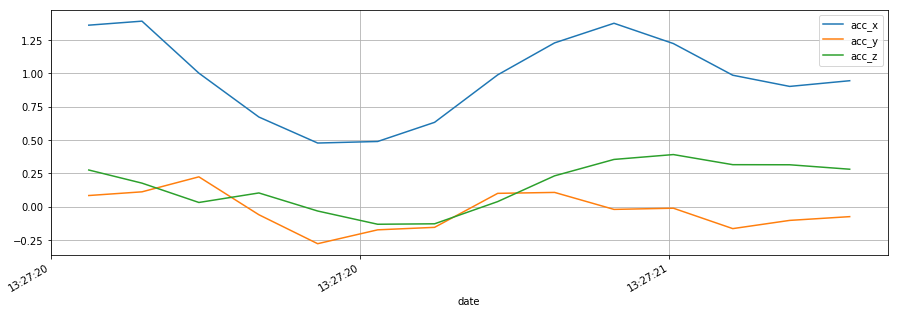

In [19]:
motionset['1'][-1][['acc_x','acc_y','acc_z']].plot(grid=True, figsize=(15,5));

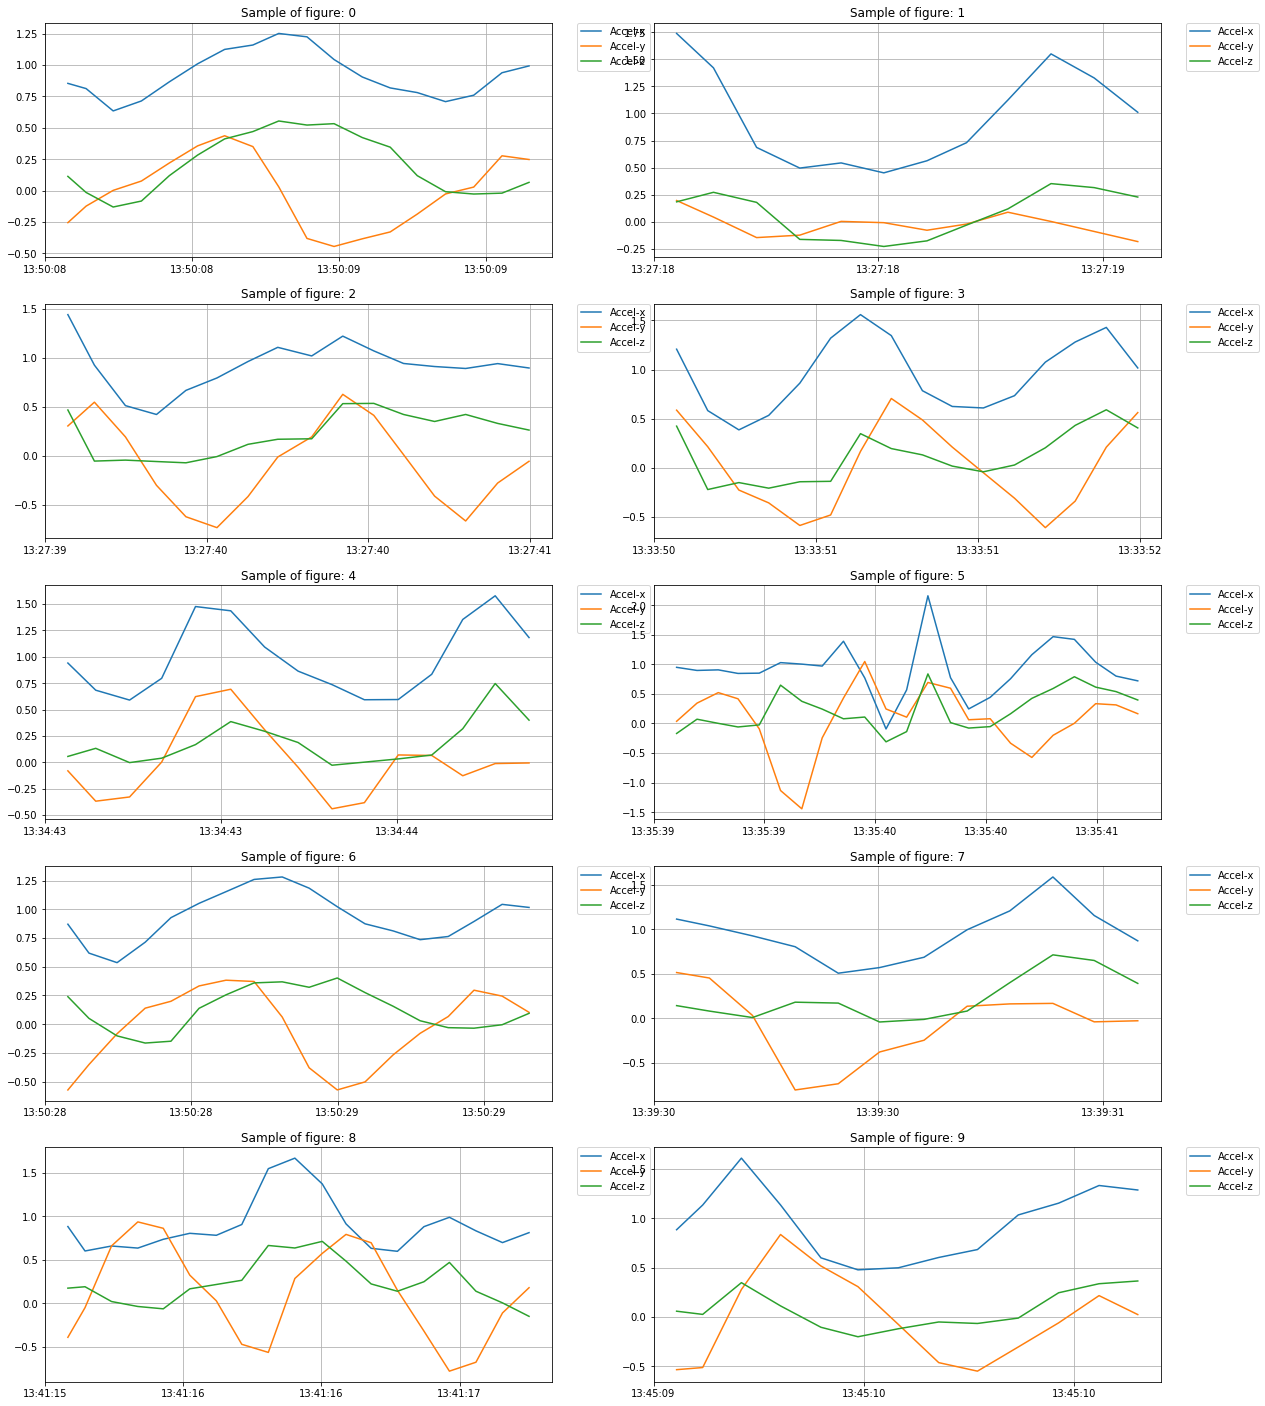

In [20]:
# Subplots are organized in a Rows x Cols Grid
figures = sorted(motionset.keys())
Tot = len(figures)
Cols = 2

# Compute Rows required
Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index
Position = range(1,Tot + 1)

# Create main figure
fig = plt.figure(1)
fig.set_size_inches(20,25)

# Create a figure on each sample motionset
i = 0 
for k in figures:    
    # add every single subplot to the figure with a for loop
    ax = fig.add_subplot(Rows,Cols,Position[i])
    df = motionset[k][-2]
    ax.plot(df.index, df[['acc_x']], label='Accel-x')
    ax.plot(df.index, df[['acc_y']], label='Accel-y')
    ax.plot(df.index, df[['acc_z']], label='Accel-z')

    ax.set_title('Sample of figure: '+ k)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(True)
    i+=1
    
plt.show()

# Build a training data set

* The idea is to transform all figures into equally long montions.
* Then we can pass them into a classical machine learning algorithms like a support vecotor classifier.
* We will achieve this by interpolating along the time axis.
* We concentrate on the accelleration features first


In [21]:
features = ['acc_x', 'acc_y', 'acc_z']

In [22]:
df = motionset['0'][2][features + ['timestamp']]
df = df.set_index('timestamp')
df.index = df.index - df.index.min()

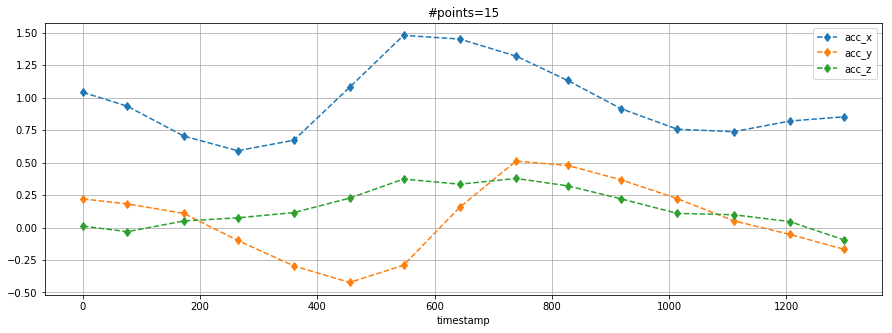

In [23]:
title="#points={:g}".format(len(df))
df.plot(style=['d--', 'd--', 'd--', ], grid=True, figsize=(15,5), title=title);

#### Make a regular time index from minimum to maximum with $n$ points

* Use numpy's linear interpolation function interp

In [24]:
import numpy as np

In [25]:
t1, t2 = df.index.min(), df.index.max()
new_index = np.linspace(t1, t2, 25)

In [26]:
np.interp(new_index, df.index, df.values[:,1])

array([ 0.2207    ,  0.19287555,  0.15720694,  0.11619375,  0.00847174,
       -0.11252075, -0.2231099 , -0.32062123, -0.39314982, -0.37740761,
       -0.29957464, -0.06768785,  0.17831875,  0.37859609,  0.50468428,
        0.48409574,  0.43155238,  0.36545729,  0.28365625,  0.19828958,
        0.10229167,  0.02375547, -0.03556719, -0.10011884, -0.1669    ])

In [27]:
ip = DataFrame(
    data = dict((col,np.interp(new_index, df.index, df[col].values)) for col in df),
    index = new_index
)
ip

,acc_x,acc_y,acc_z
0.000000,1.041100,0.220700,0.010500
54.083333,0.964956,0.192876,-0.019815
108.166667,0.857101,0.157207,-0.004524
162.250000,0.727639,0.116194,0.041841
216.333333,0.649847,0.008472,0.061958
270.416667,0.596714,-0.112521,0.077300
324.500000,0.642347,-0.223110,0.100060
378.583333,0.752032,-0.320621,0.136752
432.666667,0.984078,-0.393150,0.200058
486.750000,1.217943,-0.377408,0.276965


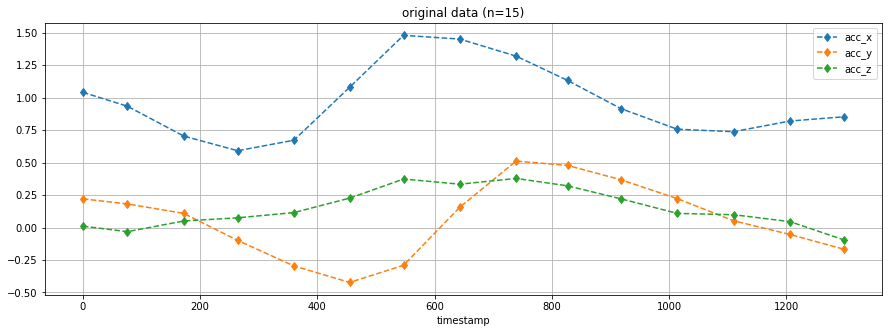

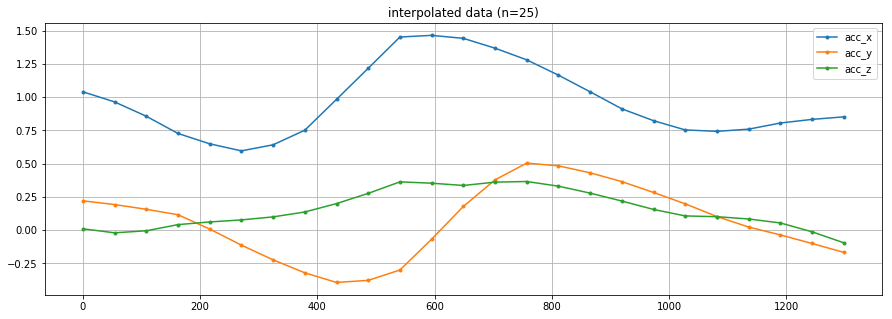

In [28]:
title="original data (n={:g})".format(len(df))
df.plot(style=['d--', 'd--', 'd--', ], grid=True, figsize=(15,5), title=title);

title="interpolated data (n={:g})".format(len(ip))
ip.plot(style=['.-', '.-', '.-', ], grid=True, figsize=(15,5), title=title);

### Combine everything into a function to make a normalized time series for each figure motion

In [29]:
def make_normalized_data(df, w=25):

    df = df.set_index('timestamp')
    df.index = (df.index - df.index.min())
    
    t1, t2 = df.index.min(), df.index.max()
    
    new_index = np.linspace(t1, t2, w)

    interp = DataFrame(
        data = dict((col, np.interp(new_index, df.index, df[col].values)) for col in df),
        index = new_index
    )
    return interp

## Data cleaning

#### Each recored motion shall have enough accelaration values

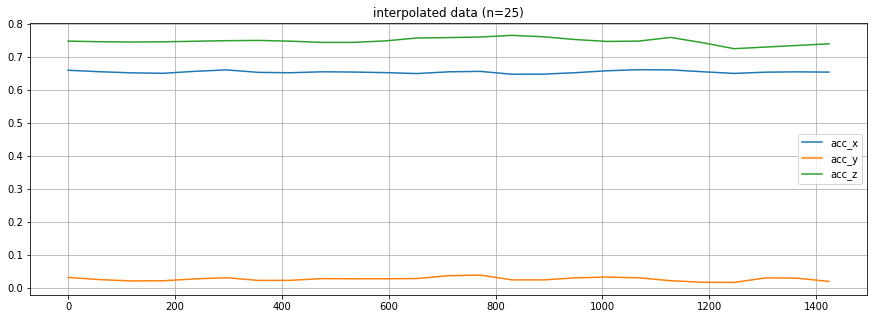

In [30]:
df = motionset['0'][0][features + ['timestamp']]
ip = make_normalized_data(df)
ip.plot(grid=True, figsize=(15,5), title=title);

In [31]:
ip.var().sum()

0.00013551082115099999

#### Each recorded motion shall have a proper duration (i.e. prober number of messages)

In [32]:
from pandas import Series
import numpy as np

# make a list of observed length
counts = [len(df) for df in motionset['1']]
print(counts)

# compute a robust estimate of the typical length
counts = Series(counts)
q25 = np.floor(counts.quantile(0.25))
q75 = np.ceil(counts.quantile(0.75))
print("quantiles:", q25, q75)

lower = q25 - 2*(q75-q25)
upper = q75 + 2*(q75-q25)
print("bounds:", lower, upper) 

[9, 10, 10, 11, 12, 11, 12, 13, 12, 12, 11, 11, 10, 12, 14]
quantiles: 10.0 12.0
bounds: 6.0 16.0


#### Padas detour: A Dataframe can easily be reshape into a vector

In [33]:
ip.values.reshape(-1)

array([ 0.6585    ,  0.0311    ,  0.7467    ,  0.65398819,  0.02448681,
        0.74490764,  0.65065797,  0.02057246,  0.74402174,  0.64923913,
        0.02102391,  0.74460217,  0.65526944,  0.02670139,  0.74634444,
        0.65959028,  0.03024514,  0.74805833,  0.65205   ,  0.022025  ,
        0.7488    ,  0.65094532,  0.02227303,  0.74659888,  0.65382917,
        0.02764097,  0.74281181,  0.6530875 ,  0.02702292,  0.74293542,
        0.65134493,  0.02706957,  0.7472808 ,  0.64850725,  0.02784348,
        0.75624529,  0.65374271,  0.03637917,  0.75735833,  0.65510729,
        0.03821215,  0.75922778,  0.64639271,  0.02368785,  0.76417222,
        0.64672323,  0.02363131,  0.75986061,  0.65113056,  0.02995   ,
        0.75147083,  0.65694028,  0.032175  ,  0.74572292,  0.660175  ,
        0.029975  ,  0.7468    ,  0.65961875,  0.02126042,  0.757925  ,
        0.65405556,  0.01658056,  0.74216806,  0.64893043,  0.01592609,
        0.72382609,  0.65267101,  0.02972754,  0.72872754,  0.65

## Build a list of relevant feature vectors and labels out of motion set

In [34]:
features = ['acc_x' ,'acc_y', 'acc_z'] # + ['gyro_x', 'gyro_y', 'gyro_z']

# vectors will contain all relevant feature vectors
vectors = []

# the corresponfing labels
labels = []

# loop over all motion sets
for figure, datasets in motionset.items():
    
    # comput robus upper and lower bounds on length
    counts = Series([len(df) for df in datasets])
    q25 = np.floor(counts.quantile(0.25))
    q75 = np.ceil(counts.quantile(0.75))
    lower = q25 - 2*(q75-q25)
    upper = q75 + 2*(q75-q25)
    
    # for each data set ...
    for df in datasets:
        # ... check its length
        if lower <= len(df) <= upper:
            # if long enough compute its normalized version
            ip = make_normalized_data(df[features + ['timestamp']])
            
            # if it has sufficient variance add it as a training example
            variance =  ip.var().sum()
            if variance > 0.01:
                vectors.append(ip.values.reshape(-1))
                labels.append(figure)
            else:
                print("Skipping motion for '{}': total variance {} to small.".format(figure, variance))
        else:
            print("Skipping motion for '{}': length {} not in range [{}, {}]".format(figure, len(df), lower, upper))

Skipping motion for '2': length 44 not in range [13.0, 18.0]
Skipping motion for '2': length 26 not in range [13.0, 18.0]
Skipping motion for '2': length 3 not in range [13.0, 18.0]
Skipping motion for '3': total variance 5.795864811118206e-06 to small.
Skipping motion for '3': total variance 0.0013848298891098215 to small.
Skipping motion for '9': length 10 not in range [11.0, 16.0]
Skipping motion for '0': total variance 0.000135510821151 to small.


### Convert to design matrix X and label vector Y

In [35]:
X = DataFrame(vectors)
Y = Series(labels)

In [36]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,...,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,0.999791,-0.116717,0.141456,0.898100,-0.016023,0.064810,0.821189,0.083707,0.008943,0.762603,...,0.265282,1.041763,0.056814,0.260299,1.011983,0.100861,0.234220,1.004306,0.105336,0.198896
std,0.241908,0.366457,0.131191,0.240537,0.329464,0.107573,0.255675,0.323290,0.111598,0.259474,...,0.244393,0.283638,0.240001,0.256458,0.222705,0.204954,0.235845,0.185342,0.211006,0.229012
min,0.475900,-0.669400,-0.169400,0.517488,-0.541354,-0.158550,0.406317,-0.477763,-0.204683,0.303770,...,-0.155128,0.495628,-0.792183,-0.150146,0.553353,-0.594142,-0.137712,0.487100,-0.396100,-0.396300
25%,0.849900,-0.412150,0.054100,0.696942,-0.332233,-0.008621,0.625739,-0.189979,-0.076845,0.600091,...,0.038473,0.792429,-0.079641,0.002426,0.859510,-0.058698,-0.008472,0.883950,-0.059200,0.005100
50%,0.971000,-0.246300,0.116500,0.863414,-0.081359,0.053835,0.720611,0.035077,-0.000874,0.676658,...,0.281528,0.959810,0.072654,0.304050,0.954039,0.120382,0.281913,0.989900,0.103700,0.227100
75%,1.101150,0.207550,0.230050,1.063947,0.285232,0.131418,0.994525,0.343034,0.078910,0.898597,...,0.441863,1.296542,0.243044,0.471977,1.207468,0.271000,0.452195,1.099000,0.265750,0.375450
max,1.750500,0.716200,0.526100,1.574461,0.670387,0.455289,1.413190,0.832412,0.296238,1.522362,...,0.906393,1.852810,0.552966,1.043262,1.548508,0.531864,0.770331,1.625400,0.669400,0.686000


In [37]:
Y.describe()

count     203
unique     10
top         6
freq       37
dtype: object

# Finally apply machine learning to build a motion classifier

## Directly apply a support vector classifier

In [38]:
from sklearn.svm import SVC

In [39]:
svm = SVC()
svm.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Evaluate what has been learnt

In [40]:
y_pred = svm.predict(X)

#### Confusion Matrix

In [41]:
from sklearn.metrics import confusion_matrix

labels=sorted(motionset.keys())
C = confusion_matrix(Y, y_pred, labels=labels)
C

array([[ 0,  0,  4,  0,  0,  0, 22,  0,  0,  0],
       [ 0, 15,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 19,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 19,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 15,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 37,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 16,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 22,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 22]])

In [42]:
# format it as a DataFrame (for nice visual)
C = DataFrame(C, columns=labels, index=labels)
C.index.name='true'
C.columns.name='pred'
C

pred,0,1,2,3,4,5,6,7,8,9
true,,,,,,,,,,
0,0,0,4,0,0,0,22,0,0,0
1,0,15,0,0,0,0,0,0,0,0
2,0,0,12,0,0,0,0,0,0,0
3,0,0,0,19,0,0,0,0,0,0
4,0,0,0,0,19,0,0,0,0,0
5,0,0,0,0,0,15,0,0,0,0
6,0,0,0,0,0,0,37,0,0,0
7,0,0,0,0,0,0,0,16,0,0
8,0,0,0,0,0,0,0,0,22,0


#### Recall / Precision / F1

* Recall ($r$): Percentage of class which was classified correctly
* Precision ($p$): Percentage of predictions of a class which are predicted correctly
* F1: $2\frac{r \cdot p}{r + p}$ ... $0 \le F1 \le 1$

In [43]:
from sklearn.metrics.classification import f1_score, precision_score, recall_score, accuracy_score

In [44]:
accuracy_score(Y, y_pred)

0.8719211822660099

In [45]:
recall_score(Y, y_pred, average='weighted')

0.8719211822660099

In [46]:
precision_score(Y, y_pred, average='weighted')

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.78917926024881013

In [47]:
f1_score(Y, y_pred, average='weighted')

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.82170713112831339

In [48]:
from sklearn.metrics.classification import classification_report, f1_score, precision_score, recall_score
print(classification_report(Y, y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        26
          1       1.00      1.00      1.00        15
          2       0.75      1.00      0.86        12
          3       1.00      1.00      1.00        19
          4       1.00      1.00      1.00        19
          5       1.00      1.00      1.00        15
          6       0.63      1.00      0.77        37
          7       1.00      1.00      1.00        16
          8       1.00      1.00      1.00        22
          9       1.00      1.00      1.00        22

avg / total       0.79      0.87      0.82       203



/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


##### Detailed look on wrong classification

In [49]:
wrong = np.where(y_pred != Y)[0]
DataFrame(
    data=[[i, Y[i], y_pred[i]] for i in wrong],
    columns=['Example', 'True', 'Predicted']
)

,Example,True,Predicted
0,112,0,2
1,113,0,2
2,114,0,2
3,115,0,2
4,116,0,6
5,117,0,6
6,118,0,6
7,119,0,6
8,120,0,6
9,121,0,6


## Make better data preparation

### Make all features 'similar' (standardization)

* subtract mean
* divide by standard deviation

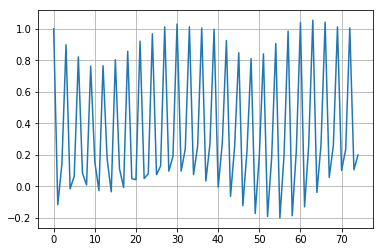

In [50]:
plt.plot(X.mean());
plt.grid(True);

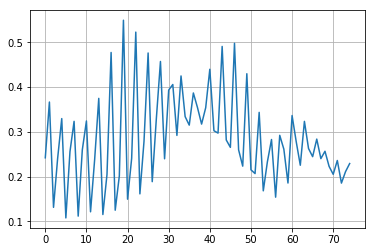

In [51]:
plt.plot(X.std());
plt.grid(True);

In [52]:
from sklearn.preprocessing import StandardScaler

In [53]:
scaler = StandardScaler()
scaler.fit(X)
X0 = scaler.transform(X)

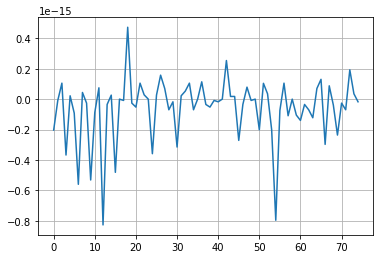

In [54]:
plt.plot(X0.mean(axis=0));
plt.grid(True);

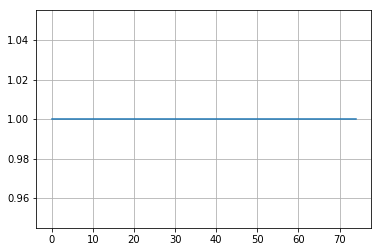

In [55]:
plt.plot(X0.std(axis=0));
plt.grid(True);

## Combine the scaler and a classifier

In [56]:
from sklearn.pipeline import Pipeline

In [57]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC()),
])

In [58]:
model.fit(X,Y)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [59]:
y_pred_train = model.predict(X)
print(classification_report(Y, y_pred_train))

             precision    recall  f1-score   support

          0       1.00      0.92      0.96        26
          1       1.00      1.00      1.00        15
          2       1.00      1.00      1.00        12
          3       1.00      1.00      1.00        19
          4       1.00      1.00      1.00        19
          5       1.00      1.00      1.00        15
          6       0.95      1.00      0.97        37
          7       1.00      1.00      1.00        16
          8       1.00      1.00      1.00        22
          9       1.00      1.00      1.00        22

avg / total       0.99      0.99      0.99       203



### Assess the generalization capability by crossvalidation

In [60]:
from sklearn.model_selection import cross_validate

In [61]:
cv = cross_validate(model, X, Y, cv=10, return_train_score=False)
DataFrame(data=cv)

,fit_time,score_time,test_score
0,0.008075,0.001019,1.000000
1,0.067210,0.002189,0.960000
2,0.007486,0.000871,0.772727
3,0.007008,0.000863,1.000000
4,0.006954,0.000855,0.954545
5,0.007168,0.000817,1.000000
6,0.007131,0.000762,1.000000
7,0.007015,0.000771,0.941176
8,0.007039,0.000764,1.000000
9,0.007134,0.000702,1.000000


In [62]:
from sklearn.model_selection import cross_val_predict

In [63]:
y_pred_cv = cross_val_predict(model, X, Y, cv=10)

In [64]:
wrong = np.where(y_pred_cv != Y)[0]
DataFrame(
    data=[[i, Y[i], y_pred_cv[i]] for i in wrong],
    columns=['Example', 'True', 'Predicted']
)

,Example,True,Predicted
0,83,6,0
1,85,6,0
2,86,6,0
3,116,0,6
4,118,0,6
5,119,0,6
6,126,0,6
7,132,0,6


In [65]:
print(classification_report(Y, y_pred_cv))

             precision    recall  f1-score   support

          0       0.88      0.81      0.84        26
          1       1.00      1.00      1.00        15
          2       1.00      1.00      1.00        12
          3       1.00      1.00      1.00        19
          4       1.00      1.00      1.00        19
          5       1.00      1.00      1.00        15
          6       0.87      0.92      0.89        37
          7       1.00      1.00      1.00        16
          8       1.00      1.00      1.00        22
          9       1.00      1.00      1.00        22

avg / total       0.96      0.96      0.96       203



### Let's try to improve the classifier

In [66]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC(kernel='rbf')),
])

In [67]:
y_pred_cv = cross_val_predict(model, X, Y, cv=10)
print(classification_report(Y, y_pred_cv))

             precision    recall  f1-score   support

          0       0.88      0.81      0.84        26
          1       1.00      1.00      1.00        15
          2       1.00      1.00      1.00        12
          3       1.00      1.00      1.00        19
          4       1.00      1.00      1.00        19
          5       1.00      1.00      1.00        15
          6       0.87      0.92      0.89        37
          7       1.00      1.00      1.00        16
          8       1.00      1.00      1.00        22
          9       1.00      1.00      1.00        22

avg / total       0.96      0.96      0.96       203



### Automatic meta parameter search

In [68]:
from sklearn.model_selection import GridSearchCV

In [76]:
gamma0 = 1.0 / (X.shape[1] * X.std().std())

svm_cv = GridSearchCV(
            estimator = SVC(kernel='rbf'),
            param_grid = [
                # variations with the RBF kernel
                dict(
                    kernel=['rbf'],
                    C=[1, 0.1, 0.01],
                    gamma=np.array([1/10, 1/5, 1/2, 1.0, 2, 4])*gamma0
                ),
                # variations with a linear kernel
                dict(
                    kernel=['linear'],
                    C=[1, 0.1, 0.01]
                )
            ],
            cv = 10,
            iid=True,
            verbose = 1
        )

model = Pipeline([
    ('scale', StandardScaler()),
    ('svc', svm_cv),
])

In [77]:
model.fit(X,Y)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    3.2s finished


Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=Fal...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1))])

In [71]:
model.named_steps['svc'].best_params_ 

{'C': 1, 'kernel': 'linear'}

In [72]:
y_pred_cv = cross_val_predict(model, X, Y, cv=10)
print(classification_report(Y, y_pred_cv))

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.6s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.6s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.6s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.6s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.6s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.7s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.8s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.7s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.7s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits
             precision    recall  f1-score   support

          0       0.88      0.88      0.88        26
          1       1.00      1.00      1.00        15
          2       1.00      1.00      1.00        12
          3       1.00      1.00      1.00        19
          4       1.00      1.00      1.00        19
          5       1.00      1.00      1.00        15
          6       0.92      0.92      0.92        37
          7       1.00      1.00      1.00        16
          8       1.00      1.00      1.00        22
          9       1.00      1.00      1.00        22

avg / total       0.97      0.97      0.97       203



[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.7s finished


In [73]:
wrong = np.where(y_pred_cv != Y)[0]
DataFrame(
    data=[[i, Y[i], y_pred_cv[i]] for i in wrong],
    columns=['Example', 'True', 'Predicted']
)

,Example,True,Predicted
0,85,6,0
1,86,6,0
2,90,6,0
3,116,0,6
4,118,0,6
5,119,0,6
